# Imports

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import collections

# Degree Network

Create a network with a desired degree - code start taken from lecture and ChatGPT was used to help create a working version. Link to chat: https://chat.openai.com/share/6d50a46c-cb21-4e5d-9173-7e5b37c031d3


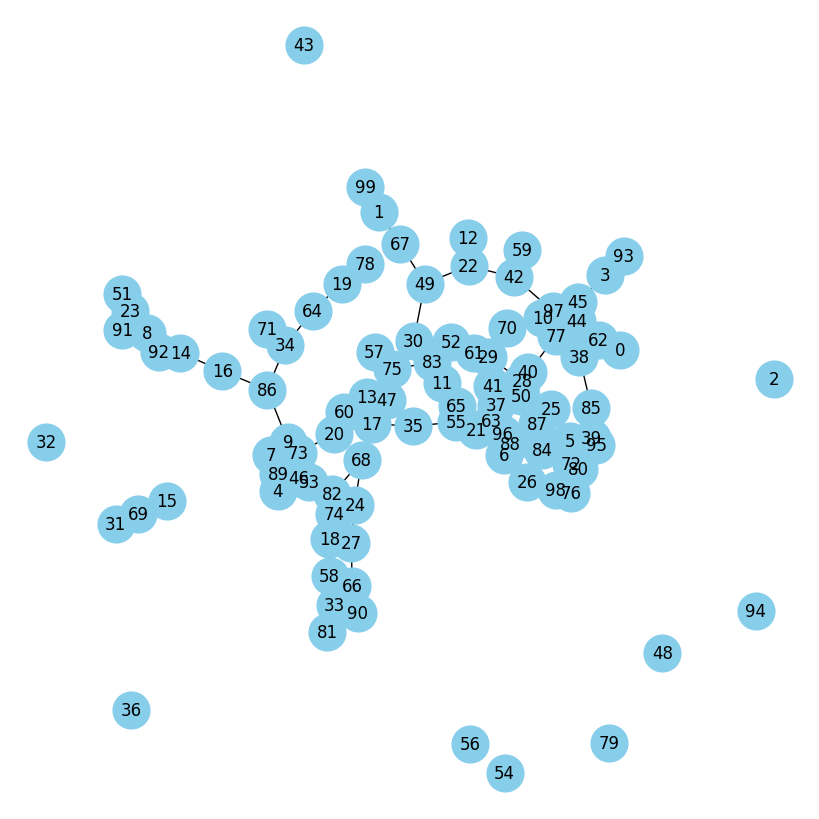

In [2]:


def configuration_A(S):
    """Configuration model with degree sequence S"""
    stubs = []
    for i in range(len(S)):
        for j in range(S[i]):
            stubs.append(i)
    n = nx.Graph()
    n.add_nodes_from(range(len(S)))  # Ensure the graph has len(S) nodes
    while len(stubs) > 1:  # Need at least 2 stubs to form an edge
        v, w = random.sample(stubs, 2)
        if v != w:  # Avoid self-loops
            n.add_edge(v, w)
            # Remove v, w from stubs
            stubs.remove(v)
            stubs.remove(w)
    return n

def configuration_B(n, P):
    """Configuration model with degree distribution P"""
    S = [1]
    while not nx.is_valid_degree_sequence_erdos_gallai(S):
        S = random.choices(population=range(len(P)), weights=P, k=n)
    return configuration_A(S)
def plot_graph(G):
    """Plot the given graph G using matplotlib"""
    plt.figure(figsize=(8, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.show()


def plot_degree_distribution(G, P):
    """Plot the degree distribution of graph G and compare it with distribution P"""
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # Also plot the theoretical distribution P for comparison
    theoretical_degrees = range(len(P))
    plt.plot(theoretical_degrees, [p*n for p in P], 'r-', label='Theoretical distribution')
    plt.legend()
    plt.show()



n = 100  # Number of nodes
P = [0.1, 0.2, 0.3, 0.4]  # Example distribution for demonstration


graph = configuration_B(n, P)
plot_graph(graph)

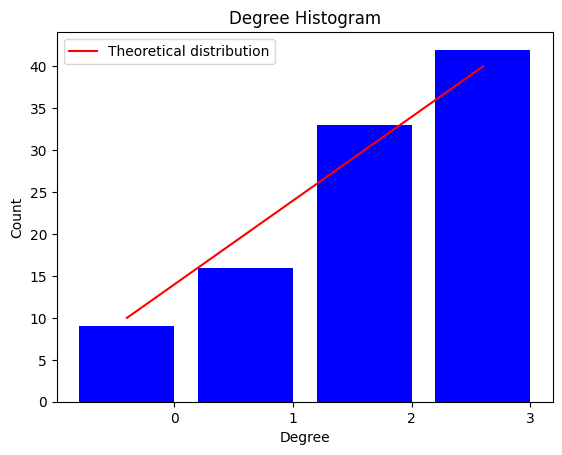

In [3]:
plot_degree_distribution(graph, P)

# Model3

Fits clustering and check with r and d

In [4]:
import networkx as nx
import random
import time
import signal

# Timeout handler
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

def model3(G, c_current, cluster, allowed_error, nodes_per_round, seed=42):
    # Seed the random number generator for reproducibility
    random.seed(seed)
    
    c_steps = [c_current]
    cluster_bound = [cluster - allowed_error, cluster + allowed_error]
    i = 0
    start_time = time.time()

    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(3600)  # Set the alarm for one hour

    try:
        while c_current < cluster_bound[0] or c_current > cluster_bound[1]:
            i += 1
            node_list = list(G.nodes())  # Refresh the node list

            # Ensure all nodes are connected to the largest component if not connected
            if not nx.is_connected(G):
                largest_cc = max(nx.connected_components(G), key=len)
                for node in node_list:
                    if node not in largest_cc:
                        G.add_edge(node, random.choice(list(largest_cc)))

            for node in node_list:
                if node not in G:
                    continue  # Ensure node still exists

                current_links = list(G.neighbors(node))
                node_degree = G.degree(node)

                if current_links:
                    # Randomly selects one link to remove
                    link_to_remove = random.choice(current_links)
                    G.remove_edge(node, link_to_remove)
                    # add logic to get degree of node on other end of link_to_remove here

                # Filter nodes with similar degree
                # CHANGE THIS TO BE OF DEGREE EQUAL TO NODE WHOSE LINK WAS REMOVED, NOT CURRENT NODE
                possible_new_links = [n for n in node_list if G.degree(n) == node_degree and n != node]

                if len(possible_new_links) > nodes_per_round:
                    selected_nodes = random.sample(possible_new_links, nodes_per_round)
                else:
                    selected_nodes = possible_new_links

                c_possible = []

                for possible in selected_nodes:
                    G.add_edge(node, possible)
                    new_c = nx.average_clustering(G)
                    c_possible.append(new_c)
                    G.remove_edge(node, possible)

                if c_possible:
                    best_node = selected_nodes[c_possible.index(max(c_possible))]
                    G.add_edge(node, best_node)

            c_current = nx.average_clustering(G)
            c_steps.append(c_current)

        signal.alarm(0)  # Disable the alarm
        execution_time = time.time() - start_time
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps

    except TimeoutException:
        print("Function execution failed due to timeout.")
        execution_time = time.time() - start_time
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps  # Returning the graph, iteration count, and clustering steps so far

# Example usage:
# G = nx.complete_graph(50)  # or any other graph initialization
# result = model3(G, nx.average_clustering(G), 0.6, 0.02, 5)

In [5]:
# check how good the model is


def analyze_graph(G):
    # Check if the graph is connected; this is required to compute the diameter
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f"Diameter of the graph: {diameter}")
    else:
        print("Graph is not connected; diameter of the giant component will be calculated.")
        # Find the largest connected component (giant component)
        giant_component = max(nx.connected_components(G), key=len)
        G_giant = G.subgraph(giant_component).copy()

        # Diameter of the giant component
        diameter = nx.diameter(G_giant)
        print(f"Diameter of the giant component: {diameter}")


    # Average Clustering Coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # Degree Distribution
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = np.bincount(degrees)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_counts)), degree_counts, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()


In [6]:
import pandas as pd
# Meet's stuff
Sydney = pd.read_csv("Sydney.csv")
SiouxFalls = pd.read_csv("SiouxFalls.csv")
Anaheim = pd.read_csv("Anaheim.csv")
BerlinFriedrichshain = pd.read_csv("Berlin-Friedrichshain.csv")
BerlinMitteCenter = pd.read_csv("Berlin-Mitte-Center.csv")
Barcelona = pd.read_csv("Barcelona.csv")
EasternMassachusetts = pd.read_csv("Eastern-Massachusetts.csv")
Winnipeg = pd.read_csv("Winnipeg.csv")

In [7]:
ana_net = bar_net = bf_net = bmc_net = em_net = sioux_net = syd_net = win_net = nx.Graph()

places = [Anaheim, Barcelona, BerlinFriedrichshain, BerlinMitteCenter, EasternMassachusetts, SiouxFalls, Sydney, Winnipeg]
graphs = [ana_net, bar_net, bf_net, bmc_net, em_net, sioux_net, syd_net, win_net]

for i in range(len(places)):
  for idx, row in places[i].iterrows():
    graphs[i].add_edge(row['init_node'], row['term_node'], **row.drop(['init_node', 'term_node']).to_dict())

In [8]:
# get a degree distribution from Eastern Massachusetts
em_degrees = [em_net.degree(n) for n in em_net.nodes()]
em_degree_counts = np.bincount(em_degrees)

In [9]:
# make that random model with that
em_graph = configuration_B(74, em_degree_counts)

In [10]:
em_graph_avg = nx.average_clustering(em_graph)

In [11]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2869
em_model, em_i, em_c_steps = model3(em_graph, em_graph_avg, c, c * 0.1, 5)

Total execution time: 925.33 seconds


In [12]:
em_model

In [13]:
em_i

9310

In [14]:
em_c_steps

[0.03573903573903573,
 0.09624624624624624,
 0.12162162162162163,
 0.06396396396396396,
 0.06222651222651223,
 0.14774774774774774,
 0.1292792792792793,
 0.07297297297297298,
 0.08712998712998714,
 0.0792792792792793,
 0.04453024453024453,
 0.1360360360360361,
 0.07342342342342341,
 0.09684684684684687,
 0.112998712998713,
 0.15244530244530247,
 0.12522522522522522,
 0.08236808236808238,
 0.12110682110682108,
 0.13063063063063063,
 0.07972972972972972,
 0.08365508365508365,
 0.10765765765765764,
 0.08738738738738738,
 0.18153153153153154,
 0.08667953667953665,
 0.13963963963963963,
 0.11853281853281854,
 0.13558558558558556,
 0.1355855855855856,
 0.13963963963963966,
 0.1189189189189189,
 0.04594594594594595,
 0.07541827541827541,
 0.10662805662805663,
 0.15765765765765768,
 0.03513513513513513,
 0.09858429858429858,
 0.16377091377091377,
 0.060810810810810814,
 0.08738738738738738,
 0.07432432432432433,
 0.0900900900900901,
 0.11531531531531533,
 0.13513513513513511,
 0.15090090090090

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 13
Average Clustering Coefficient: 0.2792792792792792


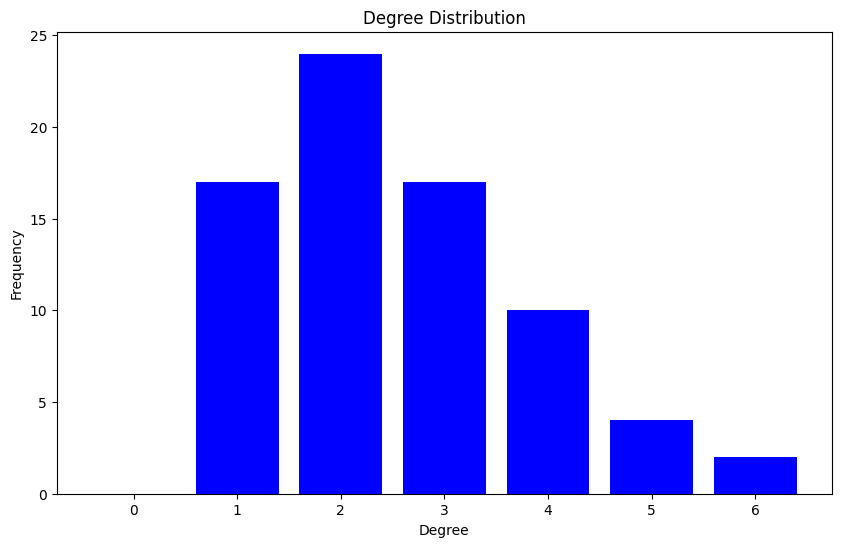

In [15]:
# compare calculated d and r values with actual values
analyze_graph(em_model)

In [16]:
nx.degree_assortativity_coefficient(em_model)

0.08243592165753544

In [17]:
# get a degree distribution from Sioux Falls
sioux_degrees = [sioux_net.degree(n) for n in sioux_net.nodes()]
sioux_degree_counts = np.bincount(sioux_degrees)

In [18]:
# make that random model with that
sioux_graph = configuration_B(24, sioux_degree_counts)

In [19]:
sioux_graph_avg = nx.average_clustering(sioux_graph)

In [20]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0528
sioux_model, sioux_i, sioux_c_steps = model3(sioux_graph, sioux_graph_avg, c, c * 0.1, 5)

Total execution time: 0.30 seconds


In [21]:
sioux_model

In [22]:
sioux_i

37

In [23]:
sioux_c_steps

[0.0853174603174603,
 0.1763888888888889,
 0.09722222222222221,
 0.09722222222222221,
 0.059722222222222225,
 0.20833333333333334,
 0.0625,
 0.16111111111111112,
 0.24722222222222223,
 0.15416666666666665,
 0.1111111111111111,
 0.1597222222222222,
 0.09166666666666667,
 0.06388888888888888,
 0.2027777777777778,
 0.1763888888888889,
 0.09722222222222221,
 0.10555555555555556,
 0.19999999999999998,
 0.34027777777777773,
 0.2222222222222223,
 0.21944444444444444,
 0.30416666666666664,
 0.2402777777777778,
 0.20138888888888887,
 0.09027777777777778,
 0.3055555555555556,
 0.10416666666666667,
 0.10555555555555556,
 0.13194444444444445,
 0.27361111111111114,
 0.30972222222222223,
 0.11805555555555554,
 0.19722222222222222,
 0.09027777777777778,
 0.06944444444444443,
 0.2222222222222222,
 0.05555555555555555]

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 11
Average Clustering Coefficient: 0.05555555555555555


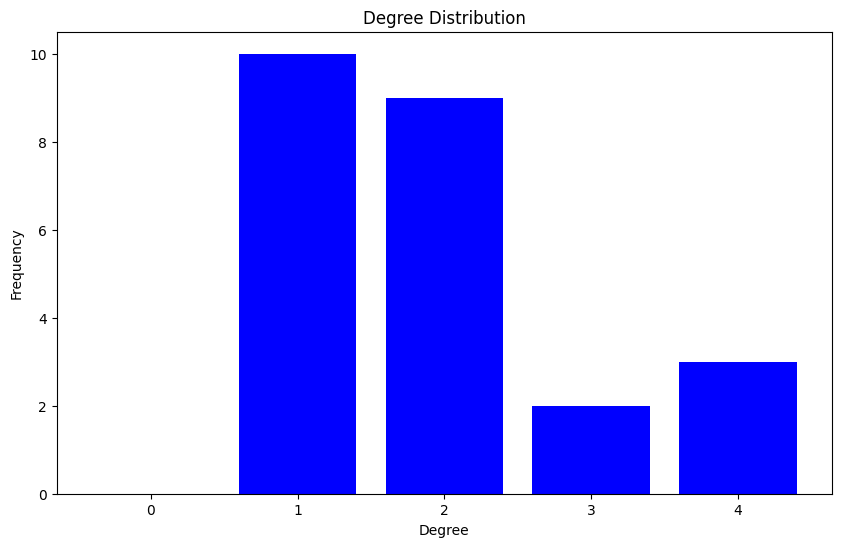

In [24]:
# compare calculated d and r values with actual values
analyze_graph(sioux_model)

In [25]:
nx.degree_assortativity_coefficient(sioux_model)

0.09591194968553406

In [26]:
# get a degree distribution from Barcelona
bar_degrees = [bar_net.degree(n) for n in bar_net.nodes()]
bar_degree_counts = np.bincount(bar_degrees)

In [27]:
# make that random model with that
bar_graph = configuration_B(1020, bar_degree_counts)

In [28]:
bar_graph_avg = nx.average_clustering(bar_graph)

In [29]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0902
bar_model, bar_i, bar_c_steps = model3(bar_graph, bar_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.05 seconds


In [30]:
bar_model

In [31]:
bar_i

101

In [32]:
bar_c_steps

[0.0007561828150063442,
 0.004393090569561157,
 0.008417366946778713,
 0.013643790849673194,
 0.015097261126672878,
 0.017096949891067525,
 0.01429738562091502,
 0.018159607277254325,
 0.017255680049797693,
 0.01922891378773731,
 0.02167755991285403,
 0.020618085618085612,
 0.017803383979854558,
 0.029056107291401435,
 0.028244348244348266,
 0.029628851540616244,
 0.026521164021164032,
 0.02632635882635883,
 0.03101092806975161,
 0.02613997113997113,
 0.029249144102085275,
 0.023817190434837508,
 0.023715494744906515,
 0.0256790595025889,
 0.02510633157691981,
 0.025469274733980606,
 0.030087885970238943,
 0.026125851272910096,
 0.027569679775562128,
 0.031029226764520905,
 0.029835594688535864,
 0.024983589395354097,
 0.028420158273099468,
 0.028845647816236077,
 0.025874572051042655,
 0.028020117137764217,
 0.029894805630099757,
 0.02464453302688599,
 0.02335046217399158,
 0.028756586550704205,
 0.025516672869614055,
 0.023515874104109394,
 0.023855920767685484,
 0.025583267495032203

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 15
Average Clustering Coefficient: 0.026384263884263896


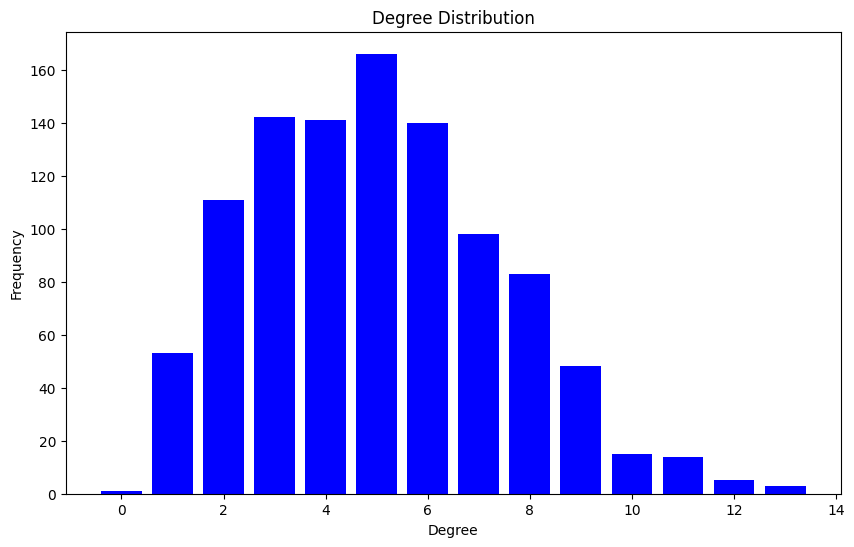

In [33]:
# compare calculated d and r values with actual values
analyze_graph(bar_model)

In [34]:
nx.degree_assortativity_coefficient(bar_model)

0.44491748178598056

In [35]:
# get a degree distribution from Sydney
syd_degrees = [syd_net.degree(n) for n in syd_net.nodes()]
syd_degree_counts = np.bincount(syd_degrees)

In [36]:
# make that random model with that
syd_graph = configuration_B(33837, syd_degree_counts)

In [37]:
syd_graph_avg = nx.average_clustering(syd_graph)

In [38]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0074
syd_model, syd_i, syd_c_steps = model3(syd_graph, syd_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.07 seconds


In [39]:
syd_model

In [40]:
syd_i

1

In [41]:
syd_c_steps

[5.654815478381397e-05]

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 30
Average Clustering Coefficient: 9.758739256035115e-05


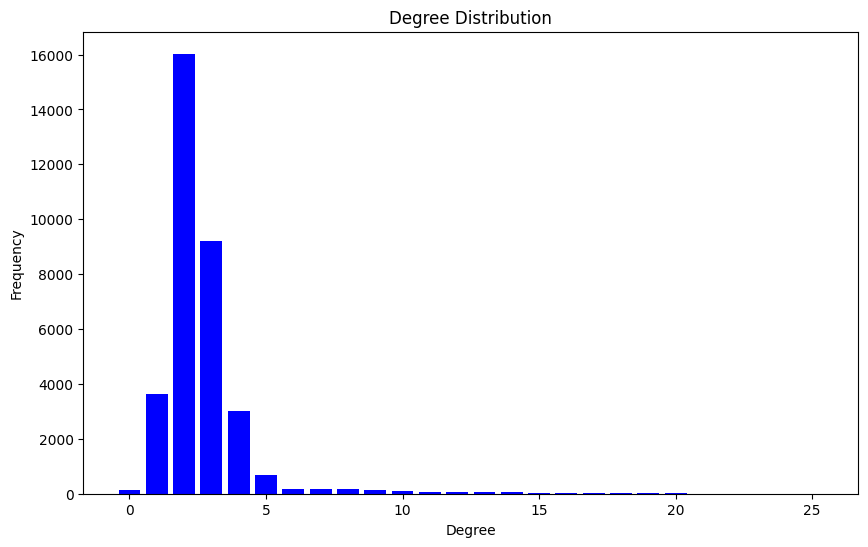

In [42]:
# compare calculated d and r values with actual values
analyze_graph(syd_model)

In [43]:
nx.degree_assortativity_coefficient(syd_model)

0.02173596248611167

In [44]:
# get a degree distribution from Winnipeg
win_degrees = [win_net.degree(n) for n in win_net.nodes()]
win_degree_counts = np.bincount(win_degrees)

In [45]:
# make that random model with that
win_graph = configuration_B(1052, win_degree_counts)

In [46]:
win_graph_avg = nx.average_clustering(win_graph)

In [47]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1045
win_model, win_i, win_c_steps = model3(win_graph, win_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.00 seconds


In [48]:
win_model

In [49]:
win_i

97

In [50]:
win_c_steps

[0.00552556336776869,
 0.010796227431208418,
 0.010591863776274416,
 0.017068773009837647,
 0.012745186794616442,
 0.014948850262538461,
 0.016758706017261135,
 0.014940551632566823,
 0.017406890743392633,
 0.023551717610652976,
 0.020644179436955096,
 0.020917416972550035,
 0.01908979803466494,
 0.017996779308566375,
 0.018712888294637343,
 0.021929892034454772,
 0.0214654800206131,
 0.021612560443358936,
 0.021930055580245703,
 0.023480664878003293,
 0.029255276831322456,
 0.023886321747538467,
 0.026120024884283444,
 0.030501696233635415,
 0.02680492300264163,
 0.026440242267238494,
 0.0334782718337852,
 0.027924404492845573,
 0.02340950663194009,
 0.0282392776214069,
 0.028246958997909556,
 0.02921841572031687,
 0.02637899700637343,
 0.02308359152465617,
 0.02818160398958879,
 0.028668152717582374,
 0.030233554995912414,
 0.027297433238497877,
 0.026771622969341626,
 0.024130458683690632,
 0.03098804448614338,
 0.029313166765638273,
 0.027133502323616394,
 0.028079519762029277,
 0.

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 15
Average Clustering Coefficient: 0.02599448502490327


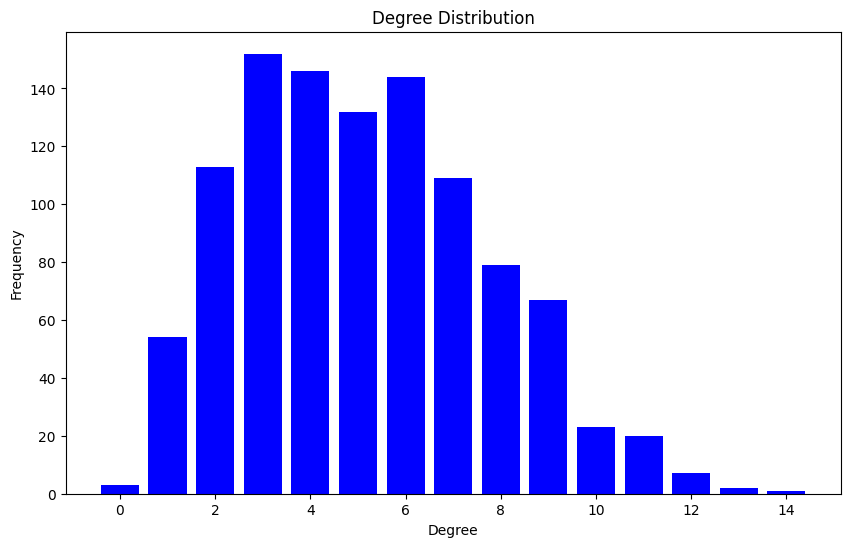

In [51]:
# compare calculated d and r values with actual values
analyze_graph(win_model)

In [52]:
nx.degree_assortativity_coefficient(win_model)

0.4358207583243191

In [53]:
# get a degree distribution from Anaheim
ana_degrees = [ana_net.degree(n) for n in ana_net.nodes()]
ana_degree_counts = np.bincount(ana_degrees)

In [54]:
# make that random model with that
ana_graph = configuration_B(416, ana_degree_counts)

In [55]:
ana_graph_avg = nx.average_clustering(ana_graph)

In [56]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1076
ana_model, ana_i, ana_c_steps = model3(ana_graph, ana_graph_avg, c, c * 0.1, 5)

In [ ]:
ana_model

In [ ]:
ana_i

1083

In [ ]:
ana_c_steps

[0.00921474358974359,
 0.012792589355089352,
 0.01455298174048174,
 0.04427210076248537,
 0.038632361228515065,
 0.028967386779886767,
 0.057761868755929854,
 0.06850964206733438,
 0.052371476091781506,
 0.05657911799738721,
 0.046670857187684094,
 0.04921979729672039,
 0.05598619512367575,
 0.05285920009477702,
 0.05162645230239448,
 0.05349920708376592,
 0.062214188055534206,
 0.0749512309494969,
 0.0721874813220967,
 0.06600039054083175,
 0.04591453355593627,
 0.05126582544215463,
 0.059285979778768275,
 0.0454067786788375,
 0.05669573325116314,
 0.052892838949042814,
 0.06186275783222231,
 0.05699472205987896,
 0.0488052059177625,
 0.05479498957801085,
 0.04265167925023695,
 0.04507514261343297,
 0.04712909678619519,
 0.04459382568474764,
 0.055738183174589166,
 0.048589969971548935,
 0.04626121152916966,
 0.06078245134605282,
 0.04190056659655076,
 0.05022590306530682,
 0.034475621235489654,
 0.05220257251860761,
 0.06176919838896648,
 0.05604149702074805,
 0.04781196171538368,
 0

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.0512020651231624


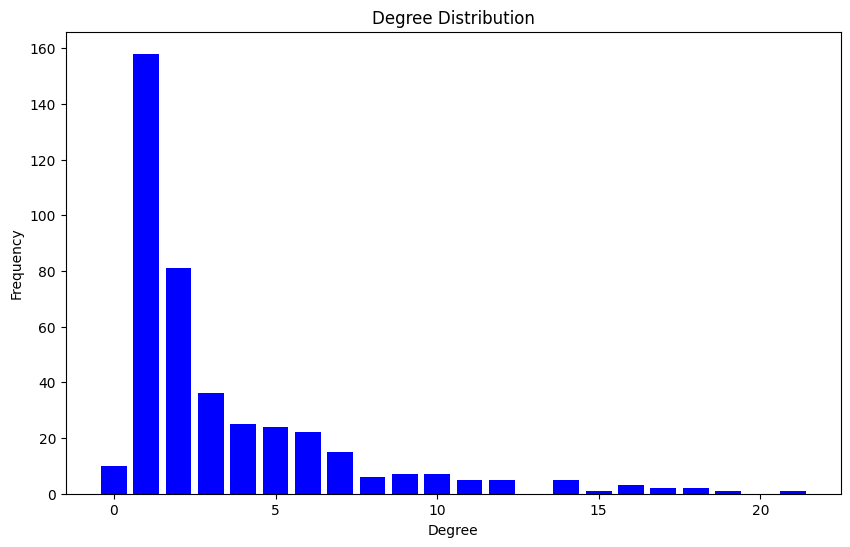

In [ ]:
# compare calculated d and r values with actual values
analyze_graph(ana_model)

In [ ]:
nx.degree_assortativity_coefficient(ana_model)

-0.3948683104036924

In [ ]:
# get a degree distribution from BerlinFriedrichshain
bf_degrees = [bf_net.degree(n) for n in bf_net.nodes()]
bf_degree_counts = np.bincount(bf_degrees)

In [ ]:
# make that random model with that
bf_graph = configuration_B(224, bf_degree_counts)

In [ ]:
bf_graph_avg = nx.average_clustering(bf_graph)

In [ ]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1915
bf_model, bf_i, bf_c_steps = model3(bf_graph, bf_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.03 seconds


In [ ]:
bf_model

In [ ]:
bf_i

4464

In [ ]:
bf_c_steps

[0.00043966450216450213,
 0.051052295918367345,
 0.021045918367346945,
 0.05846797052154194,
 0.040071956813028234,
 0.08766459235209234,
 0.06979327715934856,
 0.04872922216672215,
 0.060775385328956766,
 0.03564300283050283,
 0.07010947881483597,
 0.061259053446553434,
 0.09369484681984681,
 0.07040935255220969,
 0.06732773674737957,
 0.05885855216212356,
 0.03867479246943533,
 0.05864329123257694,
 0.05189770546913403,
 0.04630552978767261,
 0.04217848124098123,
 0.06579682718075575,
 0.05649370470799042,
 0.03855712739641311,
 0.053616745357816784,
 0.05539418418882706,
 0.07175840032982887,
 0.08583958204493916,
 0.052381175372246805,
 0.04494894985966414,
 0.06055274090988375,
 0.07306189594136023,
 0.07290626040626039,
 0.0504950654504226,
 0.0692896389324961,
 0.06060177421784563,
 0.09026620700727843,
 0.07304221076542503,
 0.0643794449598021,
 0.06324640141604425,
 0.048395528083028064,
 0.057984574948860654,
 0.05777838233195375,
 0.029547312806241375,
 0.06343391231784087,


Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 9
Average Clustering Coefficient: 0.05554472808937092


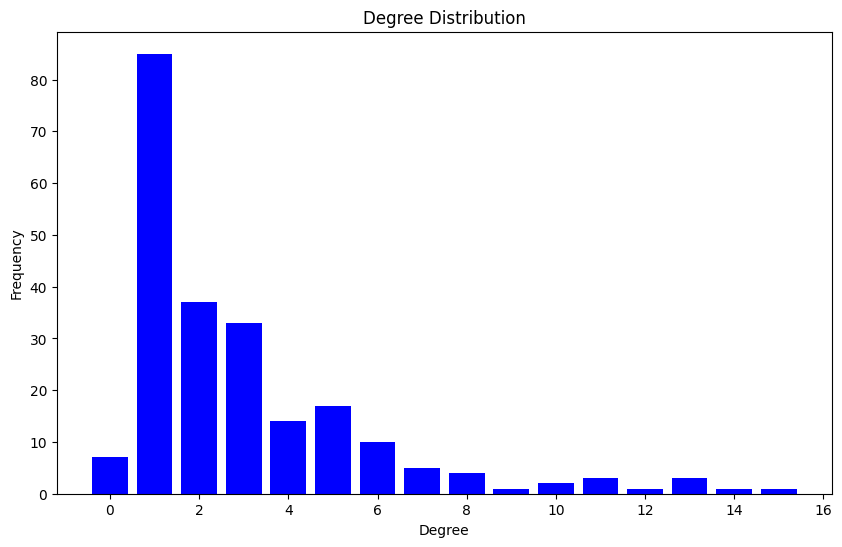

In [ ]:
# compare calculated d and r values with actual values
analyze_graph(bf_model)

In [ ]:
nx.degree_assortativity_coefficient(bf_model)

-0.32339740371345105

In [ ]:
# get a degree distribution from Berlin-Mitte-Center
bmc_degrees = [bmc_net.degree(n) for n in bmc_net.nodes()]
bmc_degree_counts = np.bincount(bmc_degrees)

In [ ]:
# make that random model with that
bmc_graph = configuration_B(398, bmc_degree_counts)

In [ ]:
bmc_graph_avg = nx.average_clustering(bmc_graph)

In [ ]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2048
bmc_model, bmc_i, bmc_c_steps = model3(bmc_graph, bmc_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.05 seconds


In [ ]:
bmc_model

In [ ]:
bmc_i

1205

In [ ]:
bmc_c_steps

[0.001016989710457047,
 0.03511261212266236,
 0.040066019965517445,
 0.040516616270385095,
 0.03458925217719188,
 0.04409685791595339,
 0.03178521440788659,
 0.029419659067900266,
 0.04746810015218622,
 0.053539681325670115,
 0.05088921818156225,
 0.027548437702147426,
 0.049697867077528546,
 0.038269849997606416,
 0.06673755033646596,
 0.05692816396333984,
 0.07206428617528234,
 0.043410709154871135,
 0.05712510445579819,
 0.061063315523114524,
 0.0474631454530952,
 0.05869739679967289,
 0.05311735562330645,
 0.050047760013805384,
 0.04399368337149347,
 0.03848900959453723,
 0.03258322580300115,
 0.06149239017625065,
 0.04988841554837165,
 0.08123967248634706,
 0.06847959585622358,
 0.062274550203941764,
 0.05048919093484023,
 0.0645467819204148,
 0.05139238204564839,
 0.054003675652360215,
 0.05674728493757851,
 0.04912053257904027,
 0.060643943126207384,
 0.06082196902844258,
 0.05173815370755956,
 0.054480317963951294,
 0.047619537303833386,
 0.06899217477106924,
 0.051274465754956

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.061218709224216655


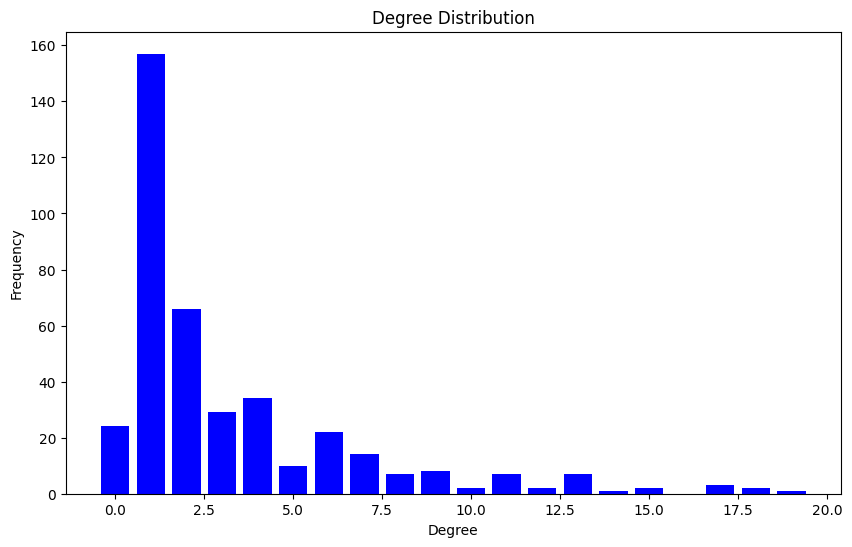

In [ ]:
# compare calculated d and r values with actual values
analyze_graph(bmc_model)

In [ ]:
nx.degree_assortativity_coefficient(bmc_model)

-0.4169771956115624